# Comparing Total Gas Masses Between Analyses - XXL-100-GC

This notebook measures gas masses for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [58]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 30
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

In [40]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 99/99 [11:34<00:00,  7.02s/it]
/tmp/ipykernel_8519/1200257332.py:10: UserWarning: The following do not appear to have any XMM data, and will not be included in the sample (can also check .failed_names); XLSSC-61, XLSSC-527
  xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False,
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:237: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


In [4]:
del xxl_srcs['XLSSC-11']

## Running PSF Correction

In [5]:
rl_psf(xxl_srcs)

## Reading in literature data

### Gas masses from literature

In [50]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

### Conversion Temperatures

In [7]:
xxl_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to $R_{500}$

In [8]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [9]:
xxl_beta_1r500_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 9/96 [03:04<29:23, 20.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 90.97108472 108.36851664 408.32353189]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:48<28:32, 20.88s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 32/96 [11:17<23:07, 21.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 205.71914867 1228.30664556 1167.34053882]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:22<18:59, 21.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.70740129 177.33787979 526.91352846]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:04<13:04, 21.19s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [30:29<03:25, 20.53s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:614: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/

In [10]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [11]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_1r500_dp)) as onwards:
    for dp in xxl_beta_1r500_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  32%|██████████▉                       | 31/96 [15:31<34:02, 31.43s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1034: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:834: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Fitting density model to XXL profiles:  45%|███████████████▏                  | 43/96 [21:43<25:54, 29.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [160.09948928 778.78323517 632.23226286]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [48:20<00:00, 30.21s/it]


In [43]:
xxl_beta_king_1r500_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_1r500_dp)) as onwards:
    for dp in xxl_beta_1r500_dp:
        if dp is not None:
            rel_src = xxl_srcs[dp.src_name]
            rel_row = xxlgc100[xxlgc100['name'] == dp.src_name]
            
            r_err = Quantity(rel_row['r500MT_err'].iloc[0], 'Mpc')
            gm = dp.gas_mass('king', rel_src.r500, radius_err=r_err)[0]
            xxl_beta_king_1r500_gm.append(gm)
        else:
            xxl_beta_king_1r500_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_beta_king_1r500_gm = Quantity(xxl_beta_king_1r500_gm, 'Msun')

Calculating XXL gas masses:   0%|                                                      | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_8519/3237557579.py:9: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm = dp.gas_mass('king', rel_src.r500, radius_err=r_err)[0]
Calculating XXL gas masses:  32%|██████████████▌                              | 31/96 [00:29<01:05,  1.01s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:504: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inn_rad, out_rad,
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [01:50<00:00,  1.15s/it]


In [44]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_beta_king_1r500_gm[:, 0]).sum(), t=len(xxl_beta_king_1r500_gm)))

93 out of 96 gas mass measurements produced a result


This section deals with two data problems, one with the literature XXL values (where an XXL gas mass is smaller than its uncertainty - messes up the plot), and another with an XGA measurement. This measurement was very low mass, and again was messing up the plot. I have made this section print the name of the cluster with this problem, but it is also removed from the gas mass array to improve the look of the figure.

In [45]:
if np.any((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]) < 0):
    xxl_lit_gms[np.argmin((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]))] = Quantity([np.NaN, np.NaN], 'Msun')

if len(xxl_beta_king_1r500_gm[xxl_beta_king_1r500_gm < Quantity(1e+9, 'Msun')]) != 0:
    which_low = np.where(xxl_beta_king_1r500_gm[:, 0] < Quantity(1e+9, 'Msun'))[0]
    print(xxl_srcs.names[which_low])
    xxl_beta_king_1r500_gm[which_low] = np.NaN

['XLSSC-54' 'XLSSC-90']


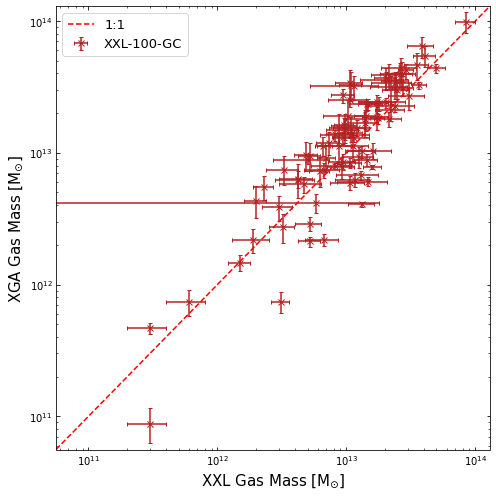

In [59]:
direct_comparison_plot(xxl_lit_gms, xxl_beta_king_1r500_gm, r"XXL Gas Mass [M$_{\odot}$]", 
                       "XGA Gas Mass [M$_{\odot}$]", "XXL-100-GC", (7, 7), dat_colour=xxlgc100_colour, 
                       savepath="../../outputs/figures/xxl_beta_king_1r500_gm_comp.pdf")

In [ ]:
# TODO - THE REST OF THE NOTEBOOK WILL BE CHANGED OR REMOVED AT SOME POINT SOON
break

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_1r500_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_1r500_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_1r500_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("../../outputs/figures/xxl_beta_king_1r500_gm_comp.pdf")
plt.show()
plt.close('all')

### Double Beta and Simplified Vikhlinin Profiles - out to $R_{500}$

In [ ]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

In [ ]:
xxl_dblbeta_1r500_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

In [ ]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

In [ ]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_1r500_dp)) as onwards:
    for dp in xxl_dblbeta_1r500_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

In [ ]:
xxl_dblbeta_svikh_1r500_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_1r500_dp)) as onwards:
    for dp in xxl_dblbeta_1r500_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_1r500_gm.append(gm)
        else:
            xxl_dblbeta_svikh_1r500_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_dblbeta_svikh_1r500_gm = Quantity(xxl_dblbeta_svikh_1r500_gm, 'Msun')

In [ ]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_dblbeta_svikh_1r500_gm[:, 0]).sum(), t=len(xxl_dblbeta_svikh_1r500_gm)))

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_1r500_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_1r500_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_1r500_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.legend(loc='best', fontsize=14)
# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')